In [1]:
import os
import sys
import pickle
import time

PROJECT_ROOT = os.path.abspath('..')
sys.path.append(PROJECT_ROOT)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import scipy
from scipy import stats
from tqdm import tqdm

from sleeprnn.helpers.reader import load_dataset
from sleeprnn.common import constants, viz, pkeys
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection.predicted_dataset import PredictedDataset
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import det_utils
from figs_thesis import fig_utils

viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

RESULTS_PATH = os.path.join(PROJECT_ROOT, 'results')
LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

/home/ntapia/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [56]:
def load_predictions(parts_to_load, dataset, thr=0.5, verbose=True):
    if thr == 0.5:
        extra_str = ''
    else:
        extra_str = '_%1.2f' % thr
    pred_objects = []
    for part in parts_to_load:
        filepath = os.path.join(
            RESULTS_PATH, 'predictions_nsrr_ss',
            'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
            'v2_time',
            'prediction%s_part%d.pkl' % (extra_str, part)
        )
        with open(filepath, 'rb') as handle:
            pred_object = pickle.load(handle)
        pred_object.set_parent_dataset(dataset)
        # Set proper page size and duration in internal parameters
        pred_object.page_duration = dataset.original_page_duration
        pred_object.page_size = int(dataset.original_page_duration * dataset.fs)
        pred_objects.append(pred_object)
    return pred_objects

# Debug

In [60]:
nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True)
predictions_1 = load_predictions([0], nsrr)[0]

Dataset nsrr_ss with 3 patients.
Loading from checkpoint... Loaded
Global STD: None
Dataset nsrr_ss with 11593 patients.


In [72]:
predictions_1.pos

6000

In [70]:
predictions_1.postprocessor.params

{'fs': 200,
 'clip_value': 10,
 'norm_computation_mode': 'norm_global',
 'shuffle_buffer_size': 100000,
 'prefetch_buffer_size': 5,
 'page_duration': 30,
 'border_duration_cwt': 2.31,
 'border_duration_conv': 0.6,
 'border_duration': None,
 'aug_indep_uniform_noise_proba': 1.0,
 'aug_indep_uniform_noise_intensity': None,
 'aug_random_waves_proba': 1.0,
 'aug_random_waves_params': None,
 'aug_random_anti_waves_proba': 1.0,
 'aug_random_anti_waves_params': None,
 'forced_separation_duration': 0,
 'total_downsampling_factor': 8,
 'aligned_downsampling': True,
 'cwt_expansion_factor': 0.9,
 'fb_list': [0.1323],
 'trainable_wavelet': True,
 'wavelet_size_factor': 1.5,
 'n_scales': 32,
 'lower_freq': 0.5,
 'upper_freq': 30,
 'cwt_noise_intensity': 0.02,
 'cwt_return_real_part': True,
 'cwt_return_imag_part': True,
 'cwt_return_magnitude': False,
 'cwt_return_phase': False,
 'model_version': None,
 'bigger_stem_filters': 64,
 'bigger_max_dilation': 8,
 'bigger_lstm_1_size': 256,
 'bigger_lstm

In [63]:
predictions_1.read_subject_data(subject_id).keys()

dict_keys(['signal', 'n2_pages', 'all_pages', 'marks_1'])

In [67]:
predictions_1.read_subject_data(subject_id)['n2_pages'].shape

(516,)

In [69]:
predictions_1.task_mode

'n2'

In [68]:
for subject_id in predictions_1.all_ids:
    marks_a = predictions_1.get_subject_stamps(subject_id, pages_subset='n2')
    marks_b = predictions_1.get_subject_stamps(subject_id, pages_subset='wn')
    diff = marks_b.shape[0]-marks_a.shape[0]
    if diff != 0:
        print(subject_id, marks_a.shape[0], marks_b.shape[0])

In [54]:
i_subject = 0

subject_id = predictions_1.all_ids[i_subject]
n2_pages = predictions_1.read_subject_data(subject_id)['n2_pages']
n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
print("N2: %d pages, %s minutes" % (n2_pages.size, n2_minutes))

# Test 1
marks_a = predictions_1.get_subject_stamps(subject_id, pages_subset='n2')
marks_b = predictions_1.get_subject_stamps(subject_id, pages_subset='wn')

page_size = int(nsrr.fs * nsrr.original_page_duration)
marks_c = utils.extract_pages_for_stamps(marks_b, n2_pages, page_size)

print(marks_a.shape, marks_b.shape, marks_c.shape)

N2: 326 pages, 163.0 minutes
(1778, 2) (1778, 2) (1778, 2)


In [36]:
signal = nsrr.read_subject_data(subject_id, exclusion_of_pages=False)['signal']
total_pages = int(signal.size / page_size)
print(total_pages)

473


In [52]:
predictions_1.page_size

4000

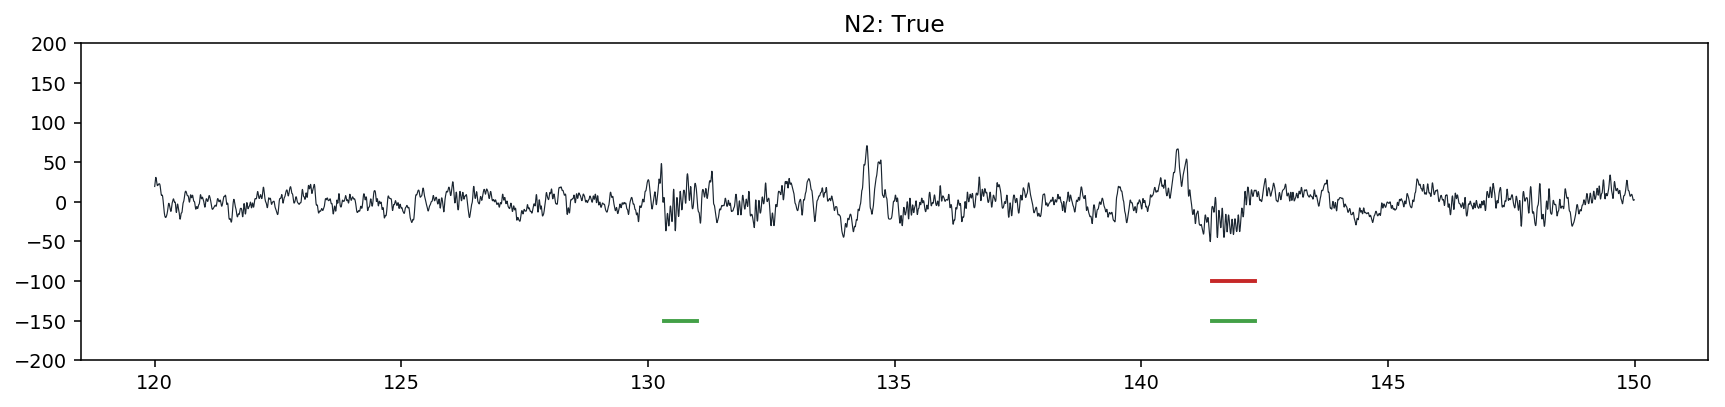

In [51]:
page_to_viz = 4


start_sample = page_to_viz * page_size
end_sample = (page_to_viz + 1) * page_size
time_axis = np.arange(start_sample, end_sample) / nsrr.fs
fig, ax = plt.subplots(1, 1, figsize=(15, 3), dpi=140)
ax.plot(time_axis, signal[start_sample:end_sample], linewidth=0.6, color=viz.PALETTE['dark'])
ax.set_ylim([-200, 200])
m_a = utils.filter_stamps(marks_a, start_sample, end_sample)
m_b = utils.filter_stamps(marks_b, start_sample, end_sample)
for m in m_a:
    ax.plot(m/nsrr.fs, [-100]*2, linewidth=2, color=viz.PALETTE['red'])
for m in m_b:
    ax.plot(m/nsrr.fs, [-150]*2, linewidth=2, color=viz.PALETTE['green'])
ax.set_title("N2: %s" % (page_to_viz in n2_pages))
plt.show()

In [21]:
stamps_start_page = np.floor(marks_b[:, 0] / page_size)
stamps_end_page = np.floor(marks_b[:, 1] / page_size)
useful_idx = np.where(
    np.isin(stamps_start_page, n2_pages) | np.isin(stamps_end_page, n2_pages)
)[0]
print(useful_idx.shape)

(1778,)


In [35]:
n2_pages

array([  1,   2,   3,   4,   5,   7,   8,   9,  10,  12,  13,  14,  15,
        16,  18,  19,  20,  22,  32,  33,  34,  37,  38,  41,  43,  44,
        46,  47,  48,  49,  50,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  64,  69,  70,  74,  77,  78,  80,  81,  82,  83,  86,
        87,  88,  91,  94,  95,  96,  97,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 110, 112, 113, 114, 117, 119, 120, 121, 122,
       123, 124, 126, 128, 129, 130, 132, 134, 135, 136, 137, 138, 141,
       142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 156, 160, 161,
       163, 164, 165, 167, 168, 169, 171, 172, 174, 176, 179, 181, 183,
       184, 185, 188, 191, 192, 193, 195, 196, 197, 199, 200, 202, 203,
       206, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 223, 226,
       227, 228, 231, 233, 235, 236, 238, 239, 240, 241, 242, 243, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 27

In [34]:
marks_b / page_size

array([[  1.068     ,   1.0825    ],
       [  2.34666667,   2.3705    ],
       [  2.69466667,   2.74383333],
       ...,
       [468.45066667, 468.48516667],
       [468.55733333, 468.58783333],
       [469.51866667, 469.5425    ]])

In [27]:
pages_to_check = np.unique(stamps_start_page)
pages_to_check.shape

(341,)

In [30]:
np.isin(stamps_start_page, n2_pages).mean()

0.9881889763779528

In [31]:
np.isin(stamps_end_page, n2_pages).mean()

0.9893138357705287

# Load NSRR dataset and pre-computed predicted dataset

In [ ]:
parts_to_load = [0]  # 0 to 11

nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True)
pred_objects_1 = load_predictions(parts_to_load, nsrr)
pred_objects_0 = load_predictions(parts_to_load, nsrr, thr=0.25)

In [ ]:
# Filenames of dataset checkpoints
byevent_proba_ckpt_path = os.path.join(
    RESULTS_PATH, 'predictions_nsrr_ss',
    'ckpt_20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
    'v2_time',
    'table_byevent_proba.csv'
)

In [ ]:
params_load_checkpoint = False

# ############################

if params_load_checkpoint:
    print("Loading from checkpoint")
    table_byevent_proba = pd.read_csv(byevent_proba_ckpt_path)

else:
    # Perform computation and save checkpoint
    table_byevent_proba = {
        'subject_id': [],
        'center_sample': [],
        'prediction_part': [],
        'category': [],
        'probability': [],
        'duration': [], 
        #'frequency': [],
        #'amplitude_pp': [],
        #'amplitude_rms': [],
        #'c10_density': [],
        #'c20_density': [],
    }

    min_n2_minutes = 60
    verbose_min_minutes = False

    start_time = time.time()
    print("Generating table of parameters")
    n_parts = len(pred_objects_1)
    
    counter = 0
    
    for part_id in range(n_parts):
        predictions_1 = pred_objects_1[part_id]
        predictions_0 = pred_objects_0[part_id]
        print("Processing Part %d / %d" % (part_id + 1, n_parts))
        for i_subject in range(10):
        # for i_subject in tqdm(range(100)):
            subject_id = predictions_1.all_ids[i_subject]
            n2_pages = predictions_1.data[subject_id]['n2_pages']
            n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
            if n2_minutes < min_n2_minutes:
                if verbose_min_minutes:
                    print("Skipped by N2 minutes: Subject %s with %d N2 minutes" % (subject_id, n2_minutes))
                continue

            # Class 1 spindles (real):
            marks_1 = predictions_1.get_subject_stamps(subject_id, pages_subset='wn')
            # Class 0 "spindles" (false):
            marks_0 = predictions_0.get_subject_stamps(subject_id, pages_subset='wn')
            # Let only those class 0 without intersecting class 1
            # If marks_1.size = 0 then marks_0 is by definition not intersecting
            if marks_1.size > 0:
                ov_mat = utils.get_overlap_matrix(marks_0, marks_1)
                is_intersecting = ov_mat.sum(axis=1)
                marks_0 = marks_0[is_intersecting == 0]
            if (marks_1.size + marks_0.size) == 0:
                continue  # There are no marks to work with
            
            #print(marks_0.shape[0], marks_1.shape[0])
            
            # Now only keep N2 stage marks
            n2_pages = predictions_1.data[subject_id]['n2_pages']
            print(n2_pages.shape)
            page_size = int(nsrr.fs * nsrr.original_page_duration)
            if marks_1.size > 0:
                #print(marks_1.shape)
                marks_1 = utils.extract_pages_for_stamps(marks_1, n2_pages, page_size)
                #print(marks_1.shape)
            #if marks_0.size > 0:
            #    marks_0 = utils.extract_pages_for_stamps(marks_0, n2_pages, page_size)
            if (marks_1.size + marks_0.size) == 0:
                continue  # There are no marks to work with
                
            print(marks_0.shape[0], marks_1.shape[0])
            
            marks = []
            marks_class = []
            if marks_1.size > 0:
                marks.append(marks_1)
                marks_class.append([1] * marks_1.shape[0])
            if marks_0.size > 0:
                marks.append(marks_0)
                marks_class.append([0] * marks_0.shape[0])
            marks = np.concatenate(marks, axis=0).astype(np.int32)
            marks_class = np.concatenate(marks_class).astype(np.int32)
            n_marks = marks.shape[0]
            counter += n_marks
            
            # Extract proba
            subject_proba = predictions_1.get_subject_probabilities(subject_id, return_adjusted=False)
            marks_proba = det_utils.get_event_probabilities(marks, subject_proba, downsampling_factor=8, proba_prc=75)
            marks_proba = marks_proba.astype(np.float32)
            
            # Parameters
            duration = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs
            
            table_byevent_proba['subject_id'].append([subject_id] * n_marks)
            table_byevent_proba['center_sample'].append(marks.mean(axis=1).astype(np.int32))
            table_byevent_proba['prediction_part'].append(np.array([part_id] * n_marks, dtype=np.int32))
            table_byevent_proba['category'].append(marks_class)
            table_byevent_proba['probability'].append(marks_proba)
            table_byevent_proba['duration'].append(duration)
            
    for key in table_byevent_proba:
        table_byevent_proba[key] = np.concatenate(table_byevent_proba[key])
    table_byevent_proba = pd.DataFrame.from_dict(table_byevent_proba)
    print("Done.") 
    
print(counter)
print(table_byevent_proba.shape)

In [ ]:
marks_1.shape

In [ ]:
a = utils.extract_pages_for_stamps(marks_1, [10], page_size)
a.shape

In [ ]:
a

In [ ]:
plt.scatter(table_byevent_proba.probability, table_byevent_proba.category)
plt.show()

In [ ]:
locs = table_byevent_proba.category == 0
plt.scatter(table_byevent_proba.probability[locs], table_byevent_proba.duration[locs], alpha=0.5)
plt.show()

In [ ]:
table_byevent_proba[
    (table_byevent_proba.category == 0) & (table_byevent_proba.probability > 0.6)
].sort_values(by="probability", ascending=False)

In [ ]:
table_byevent_proba[
    (table_byevent_proba.subject_id == "ccshs-trec-1800065") 
    & (table_byevent_proba.center_sample > 1692000)
    & (table_byevent_proba.center_sample < 1692400)
]

In [ ]:
# visualize
loc_to_viz = 5197
window_duration = 20

#
subject_info = table_byevent_proba.loc[loc_to_viz]
print(subject_info)
subject_data = nsrr.read_subject_data(subject_info.subject_id, exclusion_of_pages=False)
signal = subject_data['signal']
predictions = pred_objects_1[subject_info.prediction_part]
center_sample = subject_info.center_sample
start_sample = int(center_sample - window_duration * nsrr.fs // 2)
end_sample = int(start_sample + window_duration * nsrr.fs)
proba = predictions.get_subject_probabilities(
    subject_info.subject_id, )
proba_up = np.repeat(proba, 8)
time_axis = np.arange(start_sample, end_sample) / nsrr.fs
n2_pages = predictions.data[subject_info.subject_id]['n2_pages']
n2_pages_vector = np.zeros(signal.shape, dtype=np.int32)
page_size = int(nsrr.original_page_duration * nsrr.fs)
for p in n2_pages:
    start_page = p * page_size
    end_page = start_page + page_size
    n2_pages_vector[start_page:end_page] = 1

fig, ax = plt.subplots(1, 1, figsize=(12, 2.5), dpi=140)
ax.plot(time_axis, signal[start_sample:end_sample], linewidth=.6)
ax.fill_between(
    time_axis,
    200 * (1 - n2_pages_vector[start_sample:end_sample]),
    -200 * (1 - n2_pages_vector[start_sample:end_sample]),
    facecolor="k", alpha=0.1
)

ax.fill_between(
    time_axis, 
    -300 - 50 * proba_up[start_sample:end_sample], 
    -300 + 50 * proba_up[start_sample:end_sample],
    color=viz.PALETTE['red'], alpha=1.0
)
ax.axhline(-300 - 50, linewidth=0.7, linestyle="-", color="k")
ax.axhline(-300 + 50, linewidth=0.7, linestyle="-", color="k")
ax.axhline(-300 - 25, linewidth=0.7, linestyle="--", color="k")
ax.axhline(-300 + 25, linewidth=0.7, linestyle="--", color="k")
ax.axhline(-300 + 0, linewidth=0.7, linestyle="-", color="k")
ax.set_ylim([-400, 200])
ax.set_xlim([start_sample/nsrr.fs, end_sample/nsrr.fs])

ax.grid()
ax.set_xlabel("Time (s)", fontsize=8)
ax.tick_params(labelsize=8)
title_str = 'Subject %s. Loc %d. Center category %d' % (subject_info.subject_id, loc_to_viz, subject_info.category)
ax.set_title(title_str)
plt.tight_layout()
plt.show()

In [ ]:
signal.shape